In [1]:
import json

In [3]:
filename = 'demo1.txt'

In [6]:
header_order = {}
answer_count = 0

In [7]:
with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                record = json.loads(line)
                if "answer" in record:
                    answer_count += 1
                    for key in record["answer"].keys():
                        if key not in header_order:
                            header_order[key] = None
            except Exception as e:
                print(f"Error parsing line: {e}")


In [8]:
print(f"Number of 'answer' entries in the file: {answer_count}")

Number of 'answer' entries in the file: 36


In [9]:
print("Headers found in 'answer' (in file order):")
for h in header_order:
    print(h)

Headers found in 'answer' (in file order):
datenow
timenow
rangeIdx
dopplerIdx
numDetectedObj
x_coord
y_coord
z_coord
rp_y
doppz
interFrameProcessingTime
interFrameProcessingMargin
interChirpProcessingMargin
transmitOutputTime
activeFrameCPULoad
interFrameCPULoad
snrDB
noiseDB
activity


In [ ]:
from collections import defaultdict

# We'll group results in this dictionary
# Structure: { timenow_value : [ {'rp_y': ..., 'doppz': ...}, ... ] }
grouped_by_time = defaultdict(list)

with open(filename, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            try:
                record = json.loads(line)
                if "answer" in record:
                    ans = record["answer"]
                    time_val = ans.get("timenow", None)
                    rp_y_val = ans.get("rp_y", None)
                    doppz_val = ans.get("doppz", None)
                    if time_val is not None:
                        grouped_by_time[time_val].append({
                            "rp_y": rp_y_val,
                            "doppz": doppz_val
                        })
            except Exception as e:
                print(f"Error parsing line: {e}")

# Example: print all groups (only first 2 entries for each time to keep output short)
for t, values in grouped_by_time.items():
    print(f"timenow: {t}, entries: {len(values)}")
    for v in values[:2]:  # Show first two
        print("  rp_y:", v["rp_y"])
        print("  doppz:", v["doppz"])
    print()


timenow: 20_1_38, entries: 2
  rp_y: [92.87245725602045, 101.6681774418274, 102.93814773603482, 97.99937436967264, 89.6034596468569, 82.31288943936985, 76.36284343132398, 73.63475909561915, 70.22465367598811, 83.84155738610102, 90.54417838330684, 89.39179793115566, 84.87634799619595, 89.36827996274442, 100.49227902126498, 103.50257897790479, 100.63338683173247, 100.39820714761998, 105.54864222968341, 104.86662114575721, 94.6363048868641, 98.04641030649513, 97.62308687509265, 96.35311658088523, 90.21492682554937, 79.2790715143188, 81.16050898721868, 79.84350275618877, 76.9037567047827, 75.58675047375277, 71.72980365430801, 74.17567236907787, 71.80035755954177, 72.71755832758046, 73.56420519038541, 74.55195986365784, 74.90472938982657, 72.29423489617798, 69.96595602346439, 71.54165990701803, 70.4598333601006, 69.47207868682816, 68.36673417149947, 69.84836618140814, 69.47207868682816, 69.75429430776315, 70.31872554963311, 68.34321620308823, 69.23689900271567, 74.05808252702163, 75.5397145

In [4]:
import matplotlib.pyplot as plt

# Ensure the number of time steps
all_times = list(grouped_by_time.keys())
all_times_sorted = sorted(all_times)  # Sort for better visualization, remove if you want original order

for idx, t in enumerate(all_times_sorted):
    plt.figure(figsize=(6, 3))
    rp_y_list = [entry["rp_y"] for entry in grouped_by_time[t] if entry["rp_y"] is not None]
    # If there are multiple entries for the same timenow, plot each as a line (otherwise, one line)
    for i, rp_y in enumerate(rp_y_list):
        plt.plot(rp_y, label=f'Entry {i+1}')
    plt.title(f"rp_y at timenow: {t}")
    plt.xlabel("Index")
    plt.ylabel("rp_y (Power Profile)")
    plt.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"rpy_time_{t}.png")
    plt.close()



In [5]:
from matplotlib.animation import FuncAnimation

# Sort timenow values for smooth animation
all_times_sorted = sorted(grouped_by_time.keys())

# Create a list of rp_y arrays (take the first rp_y for each timenow if there are multiple)
rp_y_frames = []
for t in all_times_sorted:
    rp_y_list = [entry["rp_y"] for entry in grouped_by_time[t] if entry["rp_y"] is not None]
    if rp_y_list:
        rp_y_frames.append(rp_y_list[0])  # Use first entry per time, or adjust if you want to aggregate

n_frames = len(rp_y_frames)
max_length = max(len(rp) for rp in rp_y_frames)
min_val = min(min(rp) for rp in rp_y_frames)
max_val = max(max(rp) for rp in rp_y_frames)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7080\2382920803.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


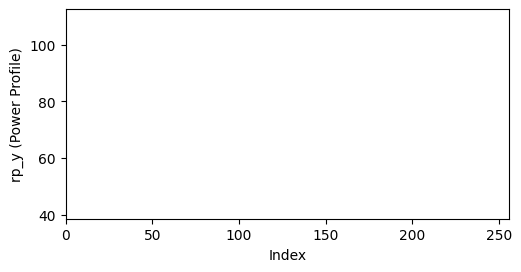

In [12]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, max_length)
ax.set_ylim(min_val, max_val)
ax.set_xlabel("Index")
ax.set_ylabel("rp_y (Power Profile)")
title = ax.set_title("")

def init():
    line.set_data([], [])
    title.set_text("")
    return line, title

def animate(i):
    y = rp_y_frames[i]
    x = list(range(len(y)))
    line.set_data(x, y)
    title.set_text(f"rp_y at timenow: {all_times_sorted[i]}")
    return line, title

ani = FuncAnimation(fig, animate, frames=n_frames, init_func=init,
                    interval=500, blit=True, repeat=True)

plt.tight_layout()
plt.show()


In [10]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [13]:
ani.save('rp_y_animation.gif', writer='pillow')
